## 1) Loading the Dataset

In [1]:
# Import the necessary packages
import random
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation,
)
import evaluate
from huggingface_hub import notebook_login

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# download data from huggingface dataset: https://huggingface.co/datasets/scene_parse_150/viewer/instance_segmentation
# size of downloaded dataset files: ~1.5GB
print("[INFO] Loading the train, val, and test dataset...")
dataset_id = 'scene_parse_150'
subset_name = 'instance_segmentation'
train = load_dataset(dataset_id, name=subset_name, split='train')
validation = load_dataset(dataset_id, name=subset_name, split='validation')
test = load_dataset(dataset_id, name=subset_name, split='test')

[INFO] Loading the train, val, and test dataset...


In [3]:
train

Dataset({
    features: ['image', 'annotation'],
    num_rows: 20210
})

In [4]:
train[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>}

In [5]:
validation

Dataset({
    features: ['image', 'annotation'],
    num_rows: 2000
})

In [6]:
test

Dataset({
    features: ['image', 'annotation'],
    num_rows: 3352
})

As described in the Scene Parsing dataset page, the instance annotation masks are stored in RGB image format and structured as follows:

The R(ed) channel encodes category ID.
The G(reen) channel encodes instance ID.
Instance IDs are assigned per image such that each object in an annotation image has a different instance ID (regardless of its class ID). In contrast, different annotation images can have objects with the same instance ID. Each image in the dataset has < 256 object instances.

[INFO] Displaying a random image and its annotation...


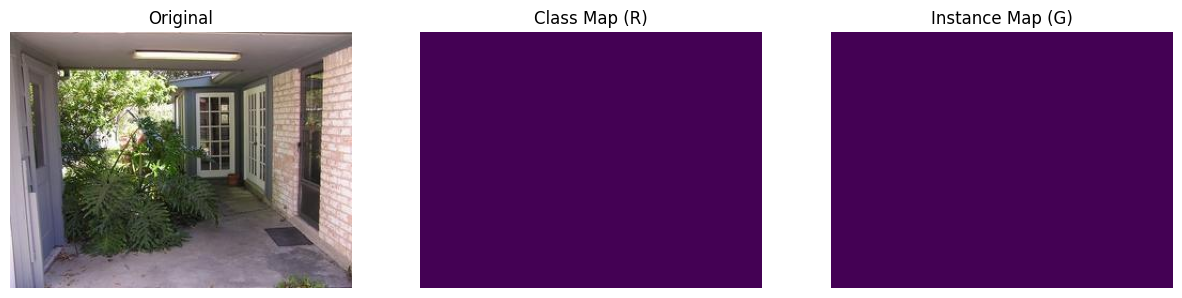

In [7]:
# Grab a random index of the training dataset
print("[INFO] Displaying a random image and its annotation...")
index = random.randint(0, len(train))

# Using the random index grab the corresponding datapoint
# from the training dataset
image = train[index]["image"]
image = np.array(image.convert("RGB"))
annotation = train[index]["annotation"]
annotation = np.array(annotation)

# Plot the original image and the annotations
plt.figure(figsize=(15, 5))
for plot_index in range(3):
    if plot_index == 0:
        # If plot index is 0 display the original image
        plot_image = image
        title = "Original"
    else:
        # Else plot the annotation maps
        plot_image = annotation[..., plot_index - 1]
        title = ["Class Map (R)", "Instance Map (G)"][plot_index - 1]

    # Plot the image
    plt.subplot(1, 3, plot_index + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis("off")

## 2) Setting Preprocessor of the dataset

In [8]:
# Create the MaskFormer Image Preprocessor
preprocessor = MaskFormerImageProcessor(
    reduce_labels=True,
    size=(512, 512),
    ignore_index=255,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)

/usr/local/lib/python3.9/site-packages/transformers/models/maskformer/image_processing_maskformer.py:419: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [9]:
preprocessor

MaskFormerImageProcessor {
  "_max_size": 1333,
  "do_normalize": false,
  "do_reduce_labels": true,
  "do_rescale": false,
  "do_resize": false,
  "ignore_index": 255,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "MaskFormerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  },
  "size_divisor": 32
}

## 3) Fine-tuning the MaskFormer Model

In [10]:
# Define the name of the model
model_name = "facebook/maskformer-swin-base-ade"

# Get the MaskFormer config and print it
config = MaskFormerConfig.from_pretrained(model_name)
print("[INFO] displaying the MaskFormer configuration...")
print(config)

[INFO] displaying the MaskFormer configuration...
MaskFormerConfig {
  "_commit_hash": "b569351e060953d37fd7dfb8b16ab83c360a13d6",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "depths": [
      2,
      2,
      18,
      2
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "drop_path_rate": 0.3,
    "early_stopping": false,
    "embed_dim": 128,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 32,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "

In [11]:
# Download SceneParsing instance segmentation labels
!wget -O /cv_huggingface_collection/instanceInfo100_train.txt https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt

--2023-12-01 18:54:20--  https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313 (3.2K) [text/plain]
Saving to: ‘/cv_huggingface_collection/instanceInfo100_train.txt’

/cv_huggingface_col 100%[===================>]   3.24K  --.-KB/s    in 0s      

2023-12-01 18:54:20 (16.4 MB/s) - ‘/cv_huggingface_collection/instanceInfo100_train.txt’ saved [3313/3313]



In [12]:
# Get a modified version of the id2label and label2id
data = pd.read_csv(
    "/cv_huggingface_collection/instanceInfo100_train.txt",
    sep="\t",
    header=0,
    on_bad_lines="skip",
)
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
label2id = {v: k for k, v in id2label.items()}

In [13]:
# Edit MaskFormer config labels
config.id2label = id2label
config.label2id = label2id

In [14]:
# Use the config object to initialize a MaskFormer model with randomized weights
model = MaskFormerForInstanceSegmentation(config)

# Replace the randomly initialized model with the pre-trained model weights
base_model = MaskFormerModel.from_pretrained(model_name)
model.model = base_model

In [15]:
# Define the configurations of the transforms specific
# to the dataset used
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# Build the augmentation transforms
train_val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

In [16]:
class ImageSegmentationDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        # Initialize the dataset, processor, and transform variables
        self.dataset = dataset
        self.processor = processor
        self.transform = transform
        
    def __len__(self):
        # Return the number of datapoints
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Convert the PIL Image to a NumPy array
        image = np.array(self.dataset[idx]["image"].convert("RGB"))
        
        # Get the pixel wise instance id and category id maps
        # of shape (height, width)
        instance_seg = np.array(self.dataset[idx]["annotation"])[..., 1]
        class_id_map = np.array(self.dataset[idx]["annotation"])[..., 0]
        class_labels = np.unique(class_id_map)

        # Build the instance to class dictionary
        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # Apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            (image, instance_seg) = (transformed["image"], transformed["mask"])
            
            # Convert from channels last to channels first
            image = image.transpose(2,0,1)

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # If the image has no objects then it is skipped
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros(
                (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
            )
        else:
            # Else use process the image with the segmentation maps
            inputs = self.processor(
                [image],
                [instance_seg],
                instance_id_to_semantic_id=inst2class,
                return_tensors="pt"
            )
            inputs = {
                k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()
            }

        # Return the inputs
        return inputs

In [17]:
# Build the train and validation instance segmentation dataset
train_dataset = ImageSegmentationDataset(
    train,
    processor=preprocessor,
    transform=train_val_transform
)
val_dataset = ImageSegmentationDataset(
    validation,
    processor=preprocessor,
    transform=train_val_transform
)

In [18]:
# Check if everything is preprocessed correctly
inputs = val_dataset[0]
for k,v in inputs.items():
  print(k, v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])


In [19]:
def collate_fn(examples):
    # Get the pixel values, pixel mask, mask labels, and class labels
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_mask = torch.stack([example["pixel_mask"] for example in examples])
    mask_labels = [example["mask_labels"] for example in examples]
    class_labels = [example["class_labels"] for example in examples]

    # Return a dictionary of all the collated features
    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "mask_labels": mask_labels,
        "class_labels": class_labels
    }

# Building the training and validation dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

In [20]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Set number of epochs and batch size
num_epochs = 2

# Load checkpoint if it exists
checkpoint_path = r'checkpoint_epoch_0.pth'
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
else: 
    start_epoch = 0

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch} | Training")

    # Set model in training mode 
    model.train()
    train_loss, val_loss = [], []

    # Training loop
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()
 
        # Forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )

        # Backward propagation
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()

        if idx % 50 == 0:
            print("  Training loss: ", round(sum(train_loss)/len(train_loss), 6))

        # Optimization
        optimizer.step()
        
        del loss
        torch.cuda.empty_cache()

    # Average train epoch loss
    train_loss = sum(train_loss)/len(train_loss)

    # Set model in evaluation mode
    model.eval()

    start_idx = 0
    print(f"Epoch {epoch} | Validation")
    for idx, batch in enumerate(tqdm(val_dataloader)):
        with torch.no_grad():
            # Forward pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            # Get validation loss
            loss = outputs.loss
            val_loss.append(loss.item())

            if idx % 50 == 0:
                print("  Validation loss: ", round(sum(val_loss)/len(val_loss), 6))

    # Average validation epoch loss
    val_loss = sum(val_loss)/len(val_loss)

    # Saving checkpoint here
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }
    
    torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
    
    # Print epoch losses
    print(f"Epoch {epoch} | train_loss: {train_loss} | validation_loss: {val_loss}")

Epoch 0 | Training


  0%|          | 0/5053 [00:00<?, ?it/s]

  Training loss:  7.248411


  1%|          | 50/5053 [00:42<1:05:33,  1.27it/s]

  Training loss:  5.768379


  2%|▏         | 100/5053 [01:23<1:07:39,  1.22it/s]

  Training loss:  4.890566


  3%|▎         | 150/5053 [02:04<1:08:15,  1.20it/s]

  Training loss:  4.812738


  4%|▍         | 200/5053 [02:46<1:08:53,  1.17it/s]

  Training loss:  4.570468


  5%|▍         | 250/5053 [03:27<1:07:25,  1.19it/s]

  Training loss:  4.356064


  6%|▌         | 300/5053 [04:09<1:05:13,  1.21it/s]

  Training loss:  4.219304


  7%|▋         | 350/5053 [04:51<1:04:14,  1.22it/s]

  Training loss:  4.101756


  8%|▊         | 400/5053 [05:32<1:04:23,  1.20it/s]

  Training loss:  4.001932


  9%|▉         | 450/5053 [06:14<1:04:35,  1.19it/s]

  Training loss:  3.927619


 10%|▉         | 500/5053 [06:56<1:05:04,  1.17it/s]

  Training loss:  3.869937


 10%|█         | 522/5053 [07:15<1:02:56,  1.20it/s]


KeyboardInterrupt: 